## 深入探讨tensorflow的工作原理

In [1]:
import tensorflow.compat.v1 as tf  #使用1.0版本的tensorflow
import numpy as np

In [9]:
g = tf.Graph()
with g.as_default():
    t1 = tf.constant(np.pi)
    t2 = tf.constant([1, 2, 3, 4])
    t3 = tf.constant([[1, 2], [3, 4]])
    #查看张量的阶数
    r1 = tf.rank(t1)
    r2 = tf.rank(t2)
    r3 = tf.rank(t3)

    #查看维度
    s1 = t1.get_shape()
    s2 = t2.get_shape()
    s3 = t3.get_shape()

    print("Shapes:", s1, s2, s3)

with tf.Session(graph=g) as sess:
    print("Ranks:",
          r1.eval(),  #评估节点
          r2.eval(),
          r3.eval())

Shapes: () (4,) (2, 2)
Ranks: 0 1 2


![](picture/计算图.png)
![](picture/计算图2.png)

In [12]:
g = tf.Graph()  #初始化一个空白图
with g.as_default():
    a = tf.constant(1, name="a")  #把节点添加到图上面
    b = tf.constant(2, name="b")
    c = tf.constant(3, name="c")
    z = 2 * (a - b) + c
with tf.Session(graph=g) as sess:  #启动一个会话来评估计算图里面的张量节点z
    print("z:", sess.run(z))

z: 1


![](picture/占位符.png)

In [15]:
g = tf.Graph()
with g.as_default():
    tf_a = tf.placeholder(tf.int32, shape=[], name='tf_a')  #定义占位符
    tf_b = tf.placeholder(tf.int32, shape=[], name='tf_b')
    tf_c = tf.placeholder(tf.int32, shape=[], name='tf_c')
    r1 = tf_a - tf_b
    r2 = 2 * r1
    z = r2 + tf_c

with tf.Session(graph=g) as sess:
    feed_dict = {tf_a: 1, tf_b: 2, tf_c: 3}
    print("z:", sess.run(z, feed_dict=feed_dict))  #计算图的节点是占位符节点时，需要提供占位符的数据

z: 1


![](picture/batchsize.png)

In [17]:
g = tf.Graph()
with g.as_default():
    tf_x = tf.placeholder(tf.float32, shape=[None, 2], name="tf_x")  #这样可以传入任意维度的x张量
    x_mean = tf.reduce_mean(tf_x, axis=0, name='mean')

with tf.Session(graph=g) as sess:
    x1 = np.random.uniform(low=0, high=2, size=(5, 2))
    print("x mean:", sess.run(x_mean, feed_dict={tf_x: x1}))
    x1 = np.random.uniform(low=0, high=2, size=(10, 2))
    print("x mean:", sess.run(x_mean, feed_dict={tf_x: x1}))

x mean: [1.3728936 0.6506112]
x mean: [0.8470377 0.5684544]


### tensorflow中的变量
![](picture/变量.png)
![](picture/变量2.png)

In [5]:
g1 = tf.Graph()
with g1.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), name="w")
    print(w)

<tf.Variable 'w:0' shape=(2, 4) dtype=int64>


In [8]:
#理解定义为变量的张量不会被分配内存空间，而且在初始化之前这些变量不包含任何值是很重要的。因此，在计算图中处理任何节点之前，必须初始化存在于要执行节点路径内的变量。这个初始化过程包括为相关张量分配内存空间并为其赋予初始值。TensorFlow提供了一个名为tf.global_variables_initializer的函数，该函数返回初始化所有计算图中现存变量的操作符。执行该操作符初始化变量如下：

with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(w))

[[1 2 3 4]
 [5 6 7 8]]


In [12]:
g2 = tf.Graph()
with g2.as_default():
    w1 = tf.Variable(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), name="w")
    # init_op=tf.global_variables_initializer()
    w2 = tf.Variable(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), name="w")
    init_op = tf.global_variables_initializer()

In [13]:
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print(sess.run(w1))

[[1 2 3 4]
 [5 6 7 8]]


In [14]:
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print(sess.run(w2))  #init_op要放在所有变量的后面

[[1 2 3 4]
 [5 6 7 8]]


![](picture/变量3.png)

In [16]:
g = tf.Graph()
with g.as_default():
    with tf.variable_scope('net_A'):
        with tf.variable_scope('layer_1'):  #嵌套的变量域
            w1 = tf.Variable(tf.random_normal(shape=(10, 4)), name='weights')
        with tf.variable_scope('layer_2'):
            w2 = tf.Variable(tf.random_normal(shape=(20, 10)), name='weights')
        with tf.variable_scope('layer_3'):
            w3 = tf.Variable(tf.random_normal(shape=(10, 4)), name='weights')

    print(w1)
    print(w2)
    print(w3)

<tf.Variable 'net_A/layer_1/weights:0' shape=(10, 4) dtype=float32>
<tf.Variable 'net_A/layer_2/weights:0' shape=(20, 10) dtype=float32>
<tf.Variable 'net_A/layer_3/weights:0' shape=(10, 4) dtype=float32>


![](picture/变量4.png)

In [22]:
#分类器
def bulid_classfier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf.get_variable(name='weights',
                              shape=(data_shape[1], n_classes),
                              dtype=tf.float32)
    bias = tf.get_variable(name='bias',
                           initializer=tf.zeros(shape=n_classes))
    logits = tf.add(tf.matmul(data, weights),
                    bias,
                    name='logits')
    return logits, tf.nn.softmax(logits)


#生成器，产生隐藏层和输出层
def bulid_generator(data, n_hidden):
    data_sahpe = data.get_shape().as_list()
    w1 = tf.Variable(tf.random_normal(shape=(data_sahpe[1], n_hidden)),
                     name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden),
                     name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1,
                    name='hidden_pre-activation')
    w2 = tf.Variable(tf.random_normal(shape=(n_hidden, data_sahpe[1])),
                     name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_sahpe[1]),
                     name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2,
                    name='output')
    return output, tf.nn.sigmoid(output)

In [26]:
batch_size = 64
g = tf.Graph()
with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100),
                          dtype=tf.float32,
                          name='tf_X')
    with tf.variable_scope('generator'):  #生成器里面的变量
        gen_out1 = bulid_generator(data=tf_X, n_hidden=50)  #产生输出层数据

    with tf.variable_scope('classfier') as scope:
        cls_out1 = bulid_classfier(data=tf_X, labels=tf.ones(shape=batch_size))  #直接放x的分类结果
        #复用变量
        scope.reuse_variables()  #复用一下上面产生的输出层数据，将其传输到分类器里面，复用变量才能使用gen_out1
        cls_out2 = bulid_classfier(data=gen_out1[1],
                                   labels=tf.ones(shape=batch_size))

In [27]:
g = tf.Graph()
with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100),
                          dtype=tf.float32,
                          name='tf_X')
    with tf.variable_scope('generator'):
        gen_out1 = bulid_generator(data=tf_X, n_hidden=50)

    with tf.variable_scope('classfier') as scope:
        cls_out1 = bulid_classfier(data=tf_X, labels=tf.ones(shape=batch_size))
        #复用变量
        #scope.reuse_variables()
    with tf.variable_scope('classfier', reuse=True):
        cls_out2 = bulid_classfier(data=gen_out1[1],
                                   labels=tf.ones(shape=batch_size))

![](picture/做回归模型.png)

In [32]:
g=tf.Graph()
with g.as_default():
    tf.set_random_seed(123)

    tf_X=tf.placeholder(shape=(None),
                        dtype=tf.float32,
                        name="tf_X")
    tf_y=tf.placeholder(shape=(None),
                        dtype=tf.float32,
                        name='tf_y')

    weight=tf.Variable(tf.random_normal(shape=(1, 1),stddev=0.25),
                  name='weight')

    bias=tf.Variable(0.0,name='bias')

    #建模
    y_hat=tf.add(weight*tf_X,bias,name='y_hat')

    cost=tf.reduce_mean(tf.square(y_hat-tf_y),
                        name='cost')

    #训练模型
    opt=tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op=opt.minimize(cost,name='train_op')

In [34]:
import matplotlib.pyplot as plt
np.random.seed(0)

def make_random_data(size):
    x=np.random.uniform(low=-2,high=4,size=size)
    y=[]
    for t in x:
        r=np.random.normal(loc=0,scale=(0.5+t*t/3),size=None)
        y.append(r)
    return x,1.726*x-0.84+np.array(y)

x,y=make_random_data(200)

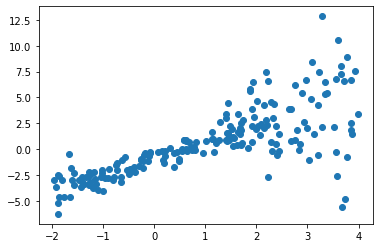

In [35]:
plt.plot(x,y,'o')
plt.show()

In [37]:
x_train,x_test=x[:100],x[100:]
y_train,y_test=y[:100],y[100:]

n_epoch=500
training_cost=[]
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(n_epoch):
        c,_=sess.run([cost,train_op],feed_dict={tf_X:x_train,tf_y:y_train})
        training_cost.append(c)
        if not e%50 :
            print('Epoch:%4d:%.4f'%(e,c))

Epoch:   0:10.0121
Epoch:  50:7.3338
Epoch: 100:6.0509
Epoch: 150:5.4111
Epoch: 200:5.0714
Epoch: 250:4.8749
Epoch: 300:4.7494
Epoch: 350:4.6613
Epoch: 400:4.5946
Epoch: 450:4.5414


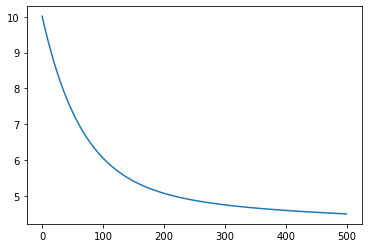

In [39]:
plt.plot(training_cost)
plt.show()

In [55]:
#在许多情况下，通过名称来执行变量和操作符非常有用。例如，我们可能在某个独立的模块开发了一个模型，根据Python的作用域规则，从其他不同的Python域无法访问该模型。然而，如果有计算图，就可以用计算图上的张量名来执行图中的节点。
n_epoch=500
training_cost=[]
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(n_epoch):
        c,_=sess.run(['cost:0','train_op'],feed_dict={'tf_X:0':x_train,'tf_y:0':y_train})
        training_cost.append(c)
        if not e%50 :
            print('Epoch:%4d:%.4f'%(e,c))

Epoch:   0:10.0121
Epoch:  50:7.3338
Epoch: 100:6.0509
Epoch: 150:5.4111
Epoch: 200:5.0714
Epoch: 250:4.8749
Epoch: 300:4.7494
Epoch: 350:4.6613
Epoch: 400:4.5946
Epoch: 450:4.5414


![](picture/保存模型.png)

In [73]:
n_epoch=500
training_cost=[]
with g.as_default():
    saver=tf.train.Saver()
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(n_epoch):
        c,_=sess.run(['cost:0','train_op'],feed_dict={'tf_X:0':x_train,'tf_y:0':y_train})
        training_cost.append(c)
        if not e%50 :
            print('Epoch:%4d:%.4f'%(e,c))
        saver.save(sess,'data/trained_model')

Epoch:   0:10.0121
Epoch:  50:7.3338
Epoch: 100:6.0509
Epoch: 150:5.4111
Epoch: 200:5.0714
Epoch: 250:4.8749
Epoch: 300:4.7494
Epoch: 350:4.6613
Epoch: 400:4.5946
Epoch: 450:4.5414


INFO:tensorflow:Restoring parameters from data/trained_model


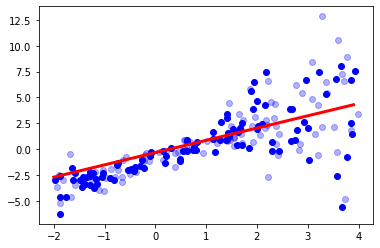

In [76]:
g2 = tf.Graph()
x_arr = np.arange(-2, 4, 0.1)
with tf.Session(graph=g2) as sess:
    new_saver = tf.train.import_meta_graph(
        'data/trained_model.meta')
    new_saver.restore(sess, 'data/trained_model')

    y_arr = sess.run('y_hat:0',
                      feed_dict={'tf_X:0' : x_arr})

plt.figure()
plt.plot(x_train, y_train, 'bo')
plt.plot(x_test, y_test, 'bo', alpha=0.3)
plt.plot(x_arr, y_arr.T[:, 0], '-r', lw=3)
# plt.savefig('images/14_05.png', dpi=400)
plt.show()

![](picture/多维张量.png)

In [4]:
g=tf.Graph()
with g.as_default():
    arr=np.array([[1.,2.,3.,4.],
                  [5.,6.,7.,8.],
                  [9.,10.,11.,12.]])
    T1=tf.constant(arr,name="T1")
    print(T1)
    s=T1.get_shape()
    print("The shape of T1 is :",s)
    T2=tf.Variable(tf.random_normal(shape=s))
    print(T2)
    T3=tf.Variable(tf.random_normal(
        shape=(s.as_list()[0],)
    ))
    print(T3)
#注意到我们用s创建T2，但无法用切片或者索引创建T3。因此通过调用s.as_list（）把s转换成常规的Python列表，然后用一般的索引方法访问。

Tensor("T1:0", shape=(3, 4), dtype=float64)
The shape of T1 is : (3, 4)
<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32>
<tf.Variable 'Variable_1:0' shape=(3,) dtype=float32>


In [5]:
with g.as_default():
    T4=tf.reshape(T1,shape=[1,1,-1],#-1会自动分配维度
                  name="T4")
    print(T4)
    T5=tf.reshape(T1,shape=[1,3,-1],
                  name='T5')
    print(T5)

Tensor("T4:0", shape=(1, 1, 12), dtype=float64)
Tensor("T5:0", shape=(1, 3, 4), dtype=float64)


In [9]:
with tf.Session(graph=g) as sess:
    print(sess.run(T4),'\n')
    print(sess.run(T5))

[[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]]] 

[[[ 1.  2.  3.  4.]
  [ 5.  6.  7.  8.]
  [ 9. 10. 11. 12.]]]


In [12]:
with g.as_default():
    T6 = tf.transpose(T5, perm=[2, 1, 0],#自定义翻转顺序
                     name='T6')
    print(T6)
    T7 = tf.transpose(T5, perm=[0, 2, 1],
                     name='T7')
    print(T7)
    t5_split=tf.split(T5,
                      num_or_size_splits=2,
                      axis=2,name="T8")
    print(t5_split)

Tensor("T6:0", shape=(4, 3, 1), dtype=float64)
Tensor("T7:0", shape=(1, 4, 3), dtype=float64)
[<tf.Tensor 'T8_1:0' shape=(1, 3, 2) dtype=float64>, <tf.Tensor 'T8_1:1' shape=(1, 3, 2) dtype=float64>]


In [13]:
with tf.Session(graph=g) as sess:
    print(sess.run(t5_split))
    print(sess.run(T6))
    print(sess.run(T7))

[array([[[ 1.,  2.],
        [ 5.,  6.],
        [ 9., 10.]]]), array([[[ 3.,  4.],
        [ 7.,  8.],
        [11., 12.]]])]
[[[ 1.]
  [ 5.]
  [ 9.]]

 [[ 2.]
  [ 6.]
  [10.]]

 [[ 3.]
  [ 7.]
  [11.]]

 [[ 4.]
  [ 8.]
  [12.]]]
[[[ 1.  5.  9.]
  [ 2.  6. 10.]
  [ 3.  7. 11.]
  [ 4.  8. 12.]]]


In [17]:
#张量的拼接,和数组的拼接是一样的
g=tf.Graph()
with g.as_default():
    t1=tf.ones(shape=(5,1),
               dtype=tf.float32,
               name='t1')
    t2=tf.zeros(shape=(5,1),
                dtype=tf.float32,
                name='t2')
    print(t1)
    print(t2)

with g.as_default():
    t3=tf.concat([t1,t2],axis=0,name='t3')
    t4=tf.concat([t1,t2],axis=1,name='t4')

    print(t3)
    print(t4)

Tensor("t1:0", shape=(5, 1), dtype=float32)
Tensor("t2:0", shape=(5, 1), dtype=float32)
Tensor("t3:0", shape=(10, 1), dtype=float32)
Tensor("t4:0", shape=(5, 2), dtype=float32)


In [18]:
with tf.Session(graph=g) as sess:
    print(sess.run(t1),'\n',sess.run(t2),'\n',sess.run(t3),'\n',sess.run(t4))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]] 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


![](picture/控制流.png)

In [26]:
g=tf.Graph()
x,y=1,2
with g.as_default():
    tf_x=tf.placeholder(shape=None,
                        dtype=tf.float32,
                        name='tf_x')
    tf_y=tf.placeholder(shape=None,
                        dtype=tf.float32,
                        name='tf_y')
    if x<y:
        res=tf.add(tf_x,tf_y,name='res')
    else:
        res=tf.subtract(tf_x,tf_y,name='res')
    print('Objiect:',res)

Objiect: Tensor("res:0", dtype=float32)


In [27]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(res,feed_dict={tf_x:x,tf_y:y}))
    x,y=2,1
    print(sess.run(res,feed_dict={tf_x:x,tf_y:y}))
#TensorFlow的计算图是静态的，这意味着一旦建立了计算图，它在执行过程中保持不变。因此，即使改变x和y的值并将新值输入到图中，这些新张量还将会在图中经过相同的路径。因此，在x＝2，y＝1和x＝1，y＝2两种情况下，得到了相同的输出值3.0。

3.0
3.0


In [29]:
#得用tensorflow的控制流
with g.as_default():
    tf_x=tf.placeholder(shape=None,
                        dtype=tf.float32,
                        name='tf_x')
    tf_y=tf.placeholder(shape=None,
                        dtype=tf.float32,
                        name='tf_y')
    res=tf.cond(tf_x<tf_y,lambda :tf.add(tf_x,tf_y,name='res_add'),
                lambda :tf.subtract(tf_x,tf_y,name='res_sub'))
    print('Objiect:',res)

Objiect: Tensor("cond_1/Identity:0", dtype=float32)


In [30]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    x,y=1,2
    print(sess.run(res,feed_dict={tf_x:x,tf_y:y}))
    x,y=2,1
    print(sess.run(res,feed_dict={tf_x:x,tf_y:y}))
#tf.case tf.

3.0
1.0


![](picture/tensorbord.png)

In [32]:
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf.get_variable(name = 'weights',
                              shape=(data_shape[1],
                                     n_classes),
                              dtype=tf.float32)
    bias = tf.get_variable(name='bias',
                           initializer=tf.zeros(
                                     shape=n_classes))
    print(weights)
    print(bias)
    logits = tf.add(tf.matmul(data, weights),
                    bias,
                    name='logits')
    print(logits)
    return logits, tf.nn.softmax(logits)


def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    w1 = tf.Variable(
        tf.random_normal(shape=(data_shape[1],
                                n_hidden)),
        name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden),
                     name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1,
                    name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')

    w2 = tf.Variable(
        tf.random_normal(shape=(n_hidden,
                                data_shape[1])),
        name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]),
                     name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2,
                    name = 'output')
    return output, tf.nn.sigmoid(output)

In [34]:
batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100),
                          dtype=tf.float32,
                          name='tf_X')

    ## build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X,
                                   n_hidden=50)

    ## build the classifier
    with tf.variable_scope('classifier') as scope:
        ## classifier for the original data:
        cls_out1 = build_classifier(data=tf_X,
                                    labels=tf.ones(
                                        shape=batch_size))

        ## reuse the classifier for generated data
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1],
                                    labels=tf.zeros(
                                        shape=batch_size))


with tf.Session(graph = g) as sess:
    sess.run(tf.global_variables_initializer())

    file_writer = tf.summary.FileWriter(logdir='data/logs/', graph=g)

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [37]:
# 在终端运行 tensorboard --logdir data/logs/

### 本章详细介绍了TensorFlow的主要功能和概念。首先讨论了TensorFlow的主要功能和优势，以及阶和张量等TensorFlow概念。然后研究了量。接着介绍了评估张量和执行运算符的不同方法，即使用Python变量或引用图中的张量名。我们进一步探讨了一些基本的TensorFlow运算符和张量变换函数，例如tf.transpose、tf.reshape、tf.split和tf.concat。最后介绍了如何使用TensorBoard可视化Tensor-Flow计算图。用该模块可视化计算图非常有用，特别是在调试复杂模型时。